Analysis Code for 

The Presence and Role of Midplane Cholesterol in Lipid Bilayers Containing Registered or Antiregistered Phase Domains

Michael D. Weiner and Gerald W. Feigenson

Journal of Physical Chemistry B, 2018

written by MDW

last updated by MDW, 2018-07-02

For MDTraj, refer to mdtraj.org or McGibbon, R. T.; Beauchamp, K. A.; Harrigan, M. P.; Klein, C.; Swails, J. M.; Hernández, C. X.; Schwantes, C. R.; Wang, L. P.; Lane, T. J.; Pande, V. S. MDTraj: A modern open library for the analysis of molecular dynamics trajectories. Biophysical Journal 2015, 109, 1528–1532.




This code is by no means highly efficient or optimized. It is well-suited to exploration of data arising from MD simulations of phase-separated lipid bilayers. It retains some steps of analysis that did not make it into the final product but might be of future interest. Any user wishing to analyze data efficiently is strongly advised to optimize the code for efficiency first and eliminate unnecessary aspects of it.

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import scipy.spatial

In [2]:
# load trajectory (xtc, trr, or gro) and its topology (gro), 
# with chosen stride (chosen after error/uncertainty analysis)
# this code uses Gromacs format files, with positions defined in nm
# some adjustment of the code would be necessary for Angstrom-based file format use
traj=md.load('dxpc35_310_8.xtc',top='dxpc35_310_8.gro',stride=24)

In [3]:
traj.n_frames

12

In [4]:
topology=traj.topology
allhead=topology.select('name PO4 or name ROH') # define single head bead for each lipid - phosphate or cholesterol hydroxyl

In [5]:
resnames=[atom.residue.name for atom in topology.atoms] # lipid type

In [6]:
# x,y coordinates of all needed for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications

allheadxy=list([] for _ in xrange(traj.n_frames)) # x,y coordinates of allhead
allheadz=list([] for _ in xrange(traj.n_frames)) # z coordinate of allhead
for nn in range(traj.n_frames):
    for i in range(len(allhead)):
        allheadi=allhead[i]
        allheadxy[nn].append(traj.xyz[nn][allheadi][0:2:1])
        allheadz[nn].append(traj.xyz[nn][allheadi][2])


In [7]:
# mdtraj can't handle neighbors for gro (rather than xtc) inputs, so do it the slow way
# this allows for using single-frame inputs (gro format)
# this time-intensive step can be put into a separate file, with the results saved and recalled using "pickle"
cutoffsq=1.0**2 #square of maximum xy distance for neighbors
neigh=list([] for _ in xrange(traj.n_frames)) # all neighbor lipids in xy plane
for nn in range(traj.n_frames):
    neigh[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allheadxy[nn])):
        xyi=allheadxy[nn][i]
        for j in range(len(allhead)-i-1): #exclude self, but will add for midplane finding; no double counting
            xyj=allheadxy[nn][j+i+1]
            distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
            if (distsq < cutoffsq):
                neigh[nn][i].append(j+i+1)
                neigh[nn][j+i+1].append(i)
  

In [8]:
#identify leaflets using tilt angles, to handle curved membranes
# tilt vector is  PO4-C4A (phospholipid) or ROH-C1 (cholesterol) (both +6 beads)
num_head=len(allhead)
tiltvectors=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    tiltvectors[nn]=list([] for _ in xrange(num_head))
    
    for i in range(num_head):
        tiltvectors[nn][i]=traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[i]+6]


In [9]:
# find length (norm) of tilt vector
# check norm length and correct for errors due to periodic boundary conditions

norms=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    norms[nn]=list([] for _ in xrange(len(allhead)))
    halfx=0.5*traj.unitcell_lengths[nn][0]
    halfy=0.5*traj.unitcell_lengths[nn][1]
    halfz=0.5*traj.unitcell_lengths[nn][2]
    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])
        if (norms[nn][i] > halfz):
            if (np.abs(tiltvectors[nn][i][0]) > halfx):
                if (tiltvectors[nn][i][0]>0): 
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]-2*halfx
                else:
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]+2*halfx
            if (np.abs(tiltvectors[nn][i][1]) > halfy):
                if (tiltvectors[nn][i][1]>0): 
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]-2*halfy
                else:
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]+2*halfy
            if (np.abs(tiltvectors[nn][i][2]) > halfz):
                if (tiltvectors[nn][i][2]>0): 
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]-2*halfz
                else:
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]+2*halfz

    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])


In [10]:
# use neighbors to find local average tilt vector for each lipid, the localvector
# this will be used to identify the leaflet of each lipid
# define the localvector as pointing outward from the upper leaflet, 
# so flip any tiltvector with a negative z direction in x,y,z before averaging
localvector=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    localvector[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        localvectorsx=[]
        localvectorsy=[]
        localvectorsz=[]
        sgn=np.sign(tiltvectors[nn][i][2]) #z-coord sign
        localvectorsx.append(sgn*tiltvectors[nn][i][0]/norms[nn][i]) #include self
        localvectorsy.append(sgn*tiltvectors[nn][i][1]/norms[nn][i]) #include self
        localvectorsz.append(sgn*tiltvectors[nn][i][2]/norms[nn][i]) #include self
        for j in range(len(neigh[nn][i])):
            sgn=np.sign(tiltvectors[nn][neigh[nn][i][j]][2])
            nor=norms[nn][neigh[nn][i][j]]
            localvectorsx.append(sgn*tiltvectors[nn][neigh[nn][i][j]][0]/nor)
            localvectorsy.append(sgn*tiltvectors[nn][neigh[nn][i][j]][1]/nor)
            localvectorsz.append(sgn*tiltvectors[nn][neigh[nn][i][j]][2]/nor)
        localvector[nn][i]=[np.mean(localvectorsx),np.mean(localvectorsy),np.mean(localvectorsz)]
       

In [11]:
# find angle between orientation vector and local average orientation vector for each lipid
# in range [0,180]
diffangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    diffangle[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        normlv=np.linalg.norm(localvector[nn][i])
        normtv=np.linalg.norm(tiltvectors[nn][i])
        cos=np.dot(localvector[nn][i],tiltvectors[nn][i])/(normlv*normtv)
        if (cos==0):
            diffangle[nn][i]=90 # exactly along midplane
        elif (cos==1 and np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2])):
            diffangle[nn][i]=0 # "perfect" upper leaflet alignment
        elif (cos==1 and not(np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2]))):
            diffangle[nn][i]=180 # "perfect" lower leaflet alignment
        else:
            diffangle[nn][i]=np.arccos(cos)*180./np.pi


In [12]:
#record leaflet in which each head is located: 0=lower, 1=upper, 2=midplane (between)
#initial pass based purely on orientation angle
head_leaflet=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    head_leaflet[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        if (diffangle[nn][i]>120): # if within 60deg of inner leaflet normal (polar angle)
            head_leaflet[nn][i]=0
        elif (diffangle[nn][i]<60): # if within 60deg of outer leaflet normal (polar angle)
            head_leaflet[nn][i]=1
        else: # if within 30deg of midplane in either direction
            head_leaflet[nn][i]=2

In [13]:
# want to identify all midplane chol and remove all "midplane" phospholipids (none exist)
# orientation angle insufficient for accurately finding midplane chol
# chol: find distance from ROH to nearest PO4; if beyond threshold, then in midplane; 
# else, copy leaflet ID of the nearest PO4 bead(do for all phospholipids, since none in midplane)
# never copy midplane (2) if trying to correct

for nn in range(traj.n_frames):
    fixedchol=0 # record how many corrected, for code checking
    fixedphos=0
    midplanechol=0 # how many chol are at midplane, for real
    for i in range(len(allhead)):
        mindist=100.0 # set very high initially
        if (head_leaflet[nn][i]==2 and (not resnames[allhead[i]]=='CHOL')): #phospholipids, must assign
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            if (mindist > 3.0): # orientation angle gave misleading result, if no other same-leaflet PO4 within 3 nm
                correct_leaflet=1-correct_leaflet
            head_leaflet[nn][i]=correct_leaflet # save corrected value
            fixedphos=fixedphos+1 # for checking code
    #must fix all phospholipids before all chols, since some may use a fixed phospholipid as their reference
    # so, must go through allhead twice
    for i in range(len(allhead)):
        mindist=100.0
        if (resnames[allhead[i]]=='CHOL'): #all chol, ignoring angle
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            if (mindist<1.4): #close to a headgroup, so in a leaflet
                head_leaflet[nn][i]=correct_leaflet
                fixedchol=fixedchol+1 # for checking code
            else: # far from all PO4, so really at midplane
                head_leaflet[nn][i]=2
                midplanechol=midplanechol+1 # for checking code

In [14]:
# calculate chol locations and collect some code-checking data
mpcholfrac=list([] for _ in xrange(traj.n_frames)) # fraction of chol that is at midplane

sep=list([] for _ in xrange(traj.n_frames)) # identify lipids by leaflet and type
for nn in range(traj.n_frames):
    sep[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        sep[nn][i]=head_leaflet[nn][i]
        if (resnames[allhead[i]]=='DIPC'):
            sep[nn][i]=sep[nn][i]+3
        if (resnames[allhead[i]]=='CHOL'):
            sep[nn][i]=sep[nn][i]+6
    
# want to confirm identification of all midplane chol
# again, find distance from ROH to nearest PO4; if beyond threshold, then in midplane
    cmindist=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        cmindist[i]=100.0
        if (resnames[allhead[i]]=='CHOL'):
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < cmindist[i] and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        cmindist[i]=dist


    truebetween=0 # midplane chol
    justfar=0 # should be zero if code working
    falseangle=0 # should be zero if code working
    inleaflet=0 # in-leaflet chol
    for i in range(len(allhead)):
        if (resnames[allhead[i]]=='CHOL'):
            if (cmindist[i]>1.4 and sep[nn][i]==8): # far from PO4 & identified as midplane
                truebetween=truebetween+1
            elif (cmindist[i]>1.4): # far from PO4 but misidentified as in-leaflet; should not exist!
                justfar=justfar+1
            else:
                if (sep[nn][i]==8): # near PO4 but misidentified as midplane; should not exist!
                    falseangle=falseangle+1
                else:
                    inleaflet=inleaflet+1 # near PO4 and correctly identified as in-leaflet
    if (justfar + falseangle > 0): #problem, as shouldn't exist - if seen in output, something is wrong!
        mpcholfrac[nn]=1000000
    else:
        mpcholfrac[nn]=float(truebetween)/(truebetween+inleaflet)


In [15]:
# only need upper leaflet heads for some calculations
upperheads=list([] for _ in xrange(traj.n_frames))
upperref=list([] for _ in xrange(traj.n_frames)) #reference: which upperhead entry is equivalent to which allhead entry
# at other times, need only lower leaflet heads
lowerheads=list([] for _ in xrange(traj.n_frames))
lowerref=list([] for _ in xrange(traj.n_frames)) 

for nn in range(traj.n_frames):
    for i in range(len(allhead)):
        if head_leaflet[nn][i]==1: # if upper
            upperheads[nn].append(allhead[i])
            upperref[nn].append(i)
        if head_leaflet[nn][i]==0: # if lower
            lowerheads[nn].append(allhead[i])
            lowerref[nn].append(i)

In [16]:
#count high-Tm lipid and chol as fraction of upper leaflet total, to find global concentration of Lo-promoting lipids
#variable name misleadingly suggests that it is only about DPPC
upperdppc=list([] for _ in xrange(traj.n_frames))
globalconc=list([] for _ in xrange(traj.n_frames)) # fraction of Lo-promoting lipids; to compare local concentration and find enrichment, defining Lo phase

for nn in range(traj.n_frames):
    upperdppc[nn]=0
    for j in range(len(upperheads[nn])):
        if(resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            upperdppc[nn]=upperdppc[nn]+1
    globalconc[nn]=float(upperdppc[nn])/len(upperheads[nn])

In [17]:
#x,y coordinates of outer leaflet lipids for calculating the Voronoi tesselation
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
# same for lower leaflet lipids
lheadxy=list([] for _ in xrange(traj.n_frames)) #lower leaflet
reg=list([] for _ in xrange(traj.n_frames)) # records whether individual lipid is registered (1) or antiregistered (0)
frac_reg=list([] for _ in xrange(traj.n_frames)) # deprecated - former method for finding registration fraction
loreg=list([] for _ in xrange(traj.n_frames)) # 1 if both registered and Lo, 0 otherwise
frac_loreg=list([] for _ in xrange(traj.n_frames)) # deprecated

num_mpc=list([] for _ in xrange(traj.n_frames)) # number of midplane chol present
comp=list([] for _ in xrange(traj.n_frames)) # composition of each phase

vphase3=list([] for _ in xrange(traj.n_frames)) # phase (Lo=1, Ld=0) of each upper leaflet lipid
lvphase3=list([] for _ in xrange(traj.n_frames)) # phase of each lower leaflet lipid


mcutoffsq=1.0**2 #square of maximum xy distance for neighbors for midplane chol; 1 nm
mneigh=list([] for _ in xrange(traj.n_frames)) # list of upper leaflet neighbors of each midplane chol
lmneigh=list([] for _ in xrange(traj.n_frames)) # list of lower leaflet neighbors of each midplane chol


mpcint=list([] for _ in xrange(traj.n_frames)) # for each midplane chol, 1 if near a phase interface, 0 otherwise

intmember=list([] for _ in xrange(traj.n_frames)) # 1 if lipid is on an interface in the upper leaflet
lintmember=list([] for _ in xrange(traj.n_frames)) # 1 if lipid is on an interface in the lower leaflet

# store xy coordinates, by leaflet, of all lipid head beads
for nn in range(traj.n_frames):
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
    for i in range(len(lowerheads[nn])):
        lowerheadsi=lowerheads[nn][i]
        lheadxy[nn].append(traj.xyz[nn][lowerheadsi][0:2:1])
    
    vor=scipy.spatial.Voronoi(np.array(headxy[nn])) # upper leaflet Voronoi tesselation
    lvor=scipy.spatial.Voronoi(np.array(lheadxy[nn])) # lower leaflet Voronoi tesselation


#generate list of neighbors, edgeneigh, that share a Voronoi cell edge; refers to upperhead index
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])

    ledgeneigh=list([] for _ in xrange(len(lowerheads[nn]))) # same for lower leaflet
    for k in range(len(lvor.ridge_points)):
        pair=lvor.ridge_points[k]
        ledgeneigh[pair[0]].append(pair[1])
        ledgeneigh[pair[1]].append(pair[0])


    vneigh=list([] for _ in xrange(len(upperheads[nn]))) # upper leaflet Voronoi neighbors by lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn]))) # upper Voronoi neighbors by upperhead index
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])

    lvneigh=list([] for _ in xrange(len(lowerheads[nn])))  #lower leaflet Voronoi neighbors by lipid type
    lvneighres=list([] for _ in xrange(len(lowerheads[nn]))) # lower Voronoi by lowerhead index
    for i in range(len(lowerheads[nn])):
        vneighheads=ledgeneigh[i] #lowerhead index, not atom
        if not vneighheads:
            lvneigh[i]=[]
            lvneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                lvneigh[i].append(resnames[lowerheads[nn][vneighheads[j]]])
                lvneighres[i].append(vneighheads[j])
           
                
#phase based on edges - simple definition: Lo (1) is enrichment of Lo-promoting lipids in Voronoi neighbors; Ld (0) otherwise
    vphase=list([] for _ in xrange(len(upperheads[nn]))) # upper leaflet
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0 # number of Lo-promoting lipids (in these systems, includes saturated lipids)
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]): # if enriched in Lo-promoting lipids
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters again
    vphase3[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[nn][i]=1
        else:
            vphase3[nn][i]=0
            

                
#phase based on edges - repeat for other leaflet
    lvphase=list([] for _ in xrange(len(lowerheads[nn]))) # for lower leaflet
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i]) #include self
        num_sat=0
        if (resnames[lowerheads[nn][j]]=='DXPC' or resnames[lowerheads[nn][j]]=='DBPC' or resnames[lowerheads[nn][j]]=='DPPC' or resnames[lowerheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(lvneigh[i])):
            if (lvneigh[i][j]=='DXPC' or lvneigh[i][j]=='DBPC' or lvneigh[i][j]=='DPPC' or lvneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]): # if enriched in Lo-promoting lipids
            lvphase[i] = 1 # Lo=1
        else:
            lvphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    lvphase2=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i])
        num_lo=0
        if (lvphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(lvneigh[i])):
            if(lvphase[lvneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            lvphase2[i]=1
        else:
            lvphase2[i]=0


#iterate edge-based phase determination to reduce small clusters again
    lvphase3[nn]=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i])
        num_lo=0
        if (lvphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(lvneigh[i])):
            if(lvphase2[lvneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            lvphase3[nn][i]=1
        else:
            lvphase3[nn][i]=0
                
                
# calculate opposite leaflet phase for each lipid; first, find the neighbors of upper leaflet lipids in the lower leaflet
    oppneigh=list([] for _ in xrange(len(upperheads[nn]))) #for upper, lower neighbors (defined by xy dist)
    for i in range(len(upperheads[nn])):
        for j in range(len(neigh[nn][upperref[nn][i]])):
            if (head_leaflet[nn][neigh[nn][upperref[nn][i]][j]]==0): # if lower
                oppneigh[i].append(resnames[allhead[neigh[nn][upperref[nn][i]][j]]])

#find phase of lower leaflet opposite each upper lipid, by local composition
    oppphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        oppneightot=len(oppneigh[i])
        num_sat=0
        for j in range(len(oppneigh[i])):
            if (oppneigh[i][j]=='DXPC' or oppneigh[i][j]=='DBPC' or oppneigh[i][j]=='DPPC' or oppneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        if (oppneightot):
            local_conc=float(num_sat)/oppneightot
        else:
            local_conc=0
        if (local_conc > globalconc[nn]):
            oppphase[i] = 1 #Lo
        else:
            oppphase[i] = 0 #Ld
    

# for more logical comparison, iterate twice, using upper Voronoi neighbors' oppphase values
    oppphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase2[i]=1
        else: 
            oppphase2[i]=0

    oppphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase2[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase3[i]=1
        else: 
            oppphase3[i]=0
        
        
# compare oppphase3 to vphase3 to check for registration
    reg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    loreg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        if (oppphase3[i]==vphase3[nn][i]):
            reg[nn][i]=1 # registered
            if (vphase3[nn][i]):
                loreg[nn][i]=1
        else:
            reg[nn][i]=0 # not registered
        if (not(loreg[nn][i]==1)):
            loreg[nn][i]=0
    frac_reg[nn]=float(sum(reg[nn]))/len(reg[nn])
    frac_loreg[nn]=float(sum(loreg[nn]))/len(reg[nn])
    

    
    
# find Voronoi edges that are domain edges as well
# find lipids that are "members" of the interface, i.e. have at least one edge on it
    intmember[nn]=list([] for _ in xrange(len(upperheads[nn]))) # for each upper lipid, 1 if on interface, 0 otherwise
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) # include self
        num_lo=0
        if (vphase3[nn][i]==1): # include self
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase3[nn][vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot # fraction of neighbors that are Lo
        if (vlocal_conc==1 or vlocal_conc==0): #all same-phase neighbors
            intmember[nn][i]=0 # not interfacial
        else: #not all neighbors belong to same phase
            intmember[nn][i]=1 # interfacial
    
    
    # repeat for lower leaflet to identify interfacial lipids there
    lintmember[nn]=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i])
        num_lo=0
        if (lvphase3[nn][i]==1):
            num_lo=num_lo+1
        for j in range(len(lvneigh[i])):
            if(lvphase3[nn][lvneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc==1 or vlocal_conc==0): #all same-phase neighbors
            lintmember[nn][i]=0
        else: #not all neighbors belong to same phase
            lintmember[nn][i]=1
  
    
    # for each midplane chol, calculate neighbor list of in-leaflet lipids to see how many are interfacial
    mneigh[nn]=list([] for _ in xrange(len(allhead)))
    lmneigh[nn]=list([] for _ in xrange(len(allhead))) # deprecated, but may still be of interest
    mpcint[nn]=list([] for _ in xrange(len(allhead)))
    num_mpc[nn]=0
    for i in range(len(allhead)):
        intneigh=0 # counter: upper neighbors that are interfacial
        lintneigh=0 # counter: lower neighbors that are interfacial
        if ((resnames[allhead[i]]=='CHOL') and (head_leaflet[nn][i]==2)): #midplane chol
            num_mpc[nn]+=1
            xyi=allheadxy[nn][i]
            for j in range(len(upperheads[nn])): # find neighbors in upper leaflet based on xy proximity
                xyj=headxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < mcutoffsq):
                    mneigh[nn][i].append(j) #upperhead index
                    if (intmember[nn][j]==1):
                        intneigh+=1
            for j in range(len(lowerheads[nn])): # find neighbors in lower leaflet based on xy proximity
                xyj=lheadxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < mcutoffsq):
                    lmneigh[nn][i].append(j) #lowerhead index
                    if (lintmember[nn][j]==1):
                        lintneigh+=1
            if (intneigh or lintneigh): # if any neighbor in either leaflet is on an interface, this midplane chol is interfacial
                mpcint[nn][i]=1
            else: # non-interfacial midplane chol
                mpcint[nn][i]=0
        else: # not a midplane chol, so unneeded
            mpcint[nn][i]=0

    

    
    
#find phase compositions for each domain
#need vphase3 & name of lipids

    dppc_lo=0
    dppc_ld=0
    dupc_lo=0
    dupc_ld=0
    chol_lo=0
    chol_ld=0
    for i in range(len(upperheads[nn])):
        name=resnames[upperheads[nn][i]]
        if (name=='DPPC' or name=='DBPC' or name=='DXPC'): # each system contains only one of these high-Tm lipids
            if (vphase3[nn][i]): # high-Tm and in Lo
                dppc_lo+=1
            else: # high-Tm and in Ld
                dppc_ld+=1
        elif (name=='DIPC'): 
            if (vphase3[nn][i]): # low-Tm and in Lo
                dupc_lo+=1
            else: # low-Tm and in Ld
                dupc_ld+=1
        elif (name=='CHOL'):
            if (vphase3[nn][i]): # chol in Lo
                chol_lo+=1
            else: # chol in Ld
                chol_ld+=1
    lo_sum=float(dppc_lo+dupc_lo+chol_lo) # total number of Lo lipids
    ld_sum=float(dppc_ld+dupc_ld+chol_ld) # total number of Ld lipids
    # composition is how much of each phase is each lipid type
    comp[nn]=[dppc_lo/lo_sum,dppc_ld/ld_sum,dupc_lo/lo_sum,dupc_ld/ld_sum,chol_lo/lo_sum,chol_ld/ld_sum]
    

In [18]:
#chol tilt angle distribution: 
mptilt=list([] for _ in xrange(traj.n_frames)) # tilt angle for midplane chol, deprecated
mptiltflat=[]  # tilt angle for midplane chol, flattened into single-dimensional list
uctiltflat=[] # tilt angle for upper leaflet chol
lctiltflat=[] # tilt angle for lower leaflet chol

for n in range(8): # assumes only final 8 frames are analyzed
    nn=traj.n_frames-8+n
    for i in range(len(allhead)):
        if (resnames[allhead[i]]=='CHOL'):
            if (head_leaflet[nn][i]==2): # midplane
                mptilt[nn].append(diffangle[nn][i])
                mptiltflat.append(diffangle[nn][i])
            elif (head_leaflet[nn][i]==1): # upper
                uctiltflat.append(diffangle[nn][i])
            elif (head_leaflet[nn][i]==0): # lower
                lctiltflat.append(diffangle[nn][i])


(0, 180, 0, 0.04)

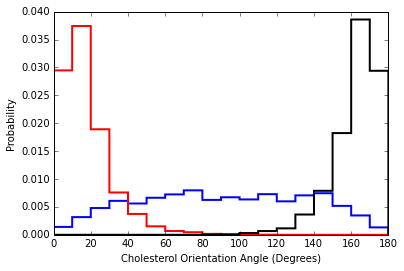

In [19]:
# plot the cholesterol tilt angle distribution histograms, as seen in publication
plt.hist(mptiltflat,histtype='step',normed='true',bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180],linewidth=2)
plt.hist(uctiltflat,histtype='step',color='r',normed='true',bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180],linewidth=2)
plt.hist(lctiltflat,histtype='step',color='k',normed='true',bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180],linewidth=2)
plt.xlabel('Cholesterol Orientation Angle (Degrees)')
plt.ylabel('Probability')
plt.axis((0,180,0,0.04))
#plt.savefig('b20tilt.pdf',format='pdf') # uncomment to save pdf of plot

In [20]:
# 4 possible locations in bilayer that midplane can experience: (R=registered, AR=antiregistered)
# R/Lo, R/Ld, AR, interfacial; this cell handles the bulk ones only


# for each midplane chol, calculate neighbor list of upper leaflet lipids to see how many are registered
# see if midplane chol tends to be near R or AR
mcutoffsq=1.0**2 #square of maximum xy distance for neighbors; 1 nm
mneigh=list([] for _ in xrange(traj.n_frames)) # upper leaflet neighbors of each midplane chol
mpc_lor=list([] for _ in xrange(traj.n_frames)) # number of midplane chol in Lo/R location
mpc_ldr=list([] for _ in xrange(traj.n_frames)) # number of midplane chol in Ld/R location
mpc_ar=list([] for _ in xrange(traj.n_frames)) # number of midplane chol in AR location

for nn in range(traj.n_frames):
    mneigh[nn]=list([] for _ in xrange(len(allhead)))
    loregneighfraci=[]
    ldregneighfraci=[]
    arneighfraci=[]
    mpc_lor[nn]=0
    mpc_ldr[nn]=0
    mpc_ar[nn]=0
    for i in range(len(allhead)):
        loregneigh=0
        ldregneigh=0
        arneigh=0
        if ((resnames[allhead[i]]=='CHOL') and (head_leaflet[nn][i]==2) and (mpcint[nn][i]==0)): #noninterfacial midplane chol
            xyi=allheadxy[nn][i]
            for j in range(len(upperheads[nn])): # find upper leaflet neighbors, check location
                xyj=headxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < mcutoffsq):
                    mneigh[nn][i].append(j) #upperhead index
                    if (loreg[nn][j]==1): # upper lipid is Lo/R
                        loregneigh+=1
                    elif (reg[nn][j]==1): # upper lipid is Ld/R
                        ldregneigh+=1
                    else: # upper lipid is AR
                        arneigh+=1
            if len(mneigh[nn][i]): # if any neighbors were found
                loregneighfraci.append(float(loregneigh)/len(mneigh[nn][i])) # fraction of which Lo/R
                ldregneighfraci.append(float(ldregneigh)/len(mneigh[nn][i])) # fraction of which Ld/R
                arneighfraci.append(float(arneigh)/len(mneigh[nn][i])) #fractino of which AR
                if (loregneighfraci[-1]>0.5): # if most neighbors are Lo/R
                    mpc_lor[nn]+=1
                elif (ldregneighfraci[-1]>0.5): # if most neighbors are Ld/R
                    mpc_ldr[nn]+=1
                elif (arneighfraci[-1]>0.5): # if most neighbors are AR
                    mpc_ar[nn]+=1
                # possible that none of these conditions met - unclassifiable, though should be interfacial anyway


In [21]:
# run lower leaflet lipids through the same process to get the normalizations (denominators) 
# for finding which locations are enriched in midplane chol


# for each, calculate neighbor list of upper leaflet lipids to see how many are of each phase
# see if midplane chol tends to be near R or AR
lcutoffsq=1.0**2 #square of maximum xy distance for neighbors; 1 nm
uneigh=list([] for _ in xrange(traj.n_frames)) # upper leaflet neighbors
denom_int=list([] for _ in xrange(traj.n_frames)) # number of lower lipids that are interfacial or opposite an interface
denom_lor=list([] for _ in xrange(traj.n_frames)) # number of lower lipids that are Lo/R
denom_ldr=list([] for _ in xrange(traj.n_frames)) # number of lower lipids that are Ld/R
denom_ar=list([] for _ in xrange(traj.n_frames)) # number of lower lipids that are AR
frac_denom_int=list([] for _ in xrange(traj.n_frames)) # fraction of lower lipids that are interfacial or opposite interface
frac_denom_lor=list([] for _ in xrange(traj.n_frames)) # fraction of lower lipids that are Lo/R
frac_denom_ldr=list([] for _ in xrange(traj.n_frames)) # fraction of lower lipids that are Ld/R
frac_denom_ar=list([] for _ in xrange(traj.n_frames)) # fraction of lower lipids that are AR


for nn in range(traj.n_frames):
    uneigh[nn]=list([] for _ in xrange(len(allhead)))
    denom_int[nn]=0
    denom_lor[nn]=0
    denom_ldr[nn]=0
    denom_ar[nn]=0
    
    lower_index=0
    for i in range(len(allhead)):
        intoppneigh=0
        intsameneigh=0
        loneigh=0
        ldneigh=0
        if (head_leaflet[nn][i]==0): # only do for lower lipids
            xyi=allheadxy[nn][i]
            for j in range(len(upperheads[nn])):
                xyj=headxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < lcutoffsq):
                    uneigh[nn][i].append(j) #upperhead index
                    if (intmember[nn][j]): # upper lipid is interfacial
                        intoppneigh+=1
                    elif (vphase3[nn][j]): # upper lipid is Lo
                        loneigh+=1
                    else: # upper lipid is Ld
                        ldneigh+=1
            for j in range(len(lowerheads[nn])): # must check lower neighbors also, to see if interfacial in either leaflet
                xyj=lheadxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < lcutoffsq):
                    if (lintmember[nn][j]):
                        intsameneigh+=1
                    
            if len(uneigh[nn][i]): # if any upper leaflet neighbors
                if (intoppneigh or intsameneigh): # if nearby interface in either leaflet
                    denom_int[nn]+=1
                elif (loneigh>=ldneigh): # if upper neighbors mostly Lo
                    if (lvphase3[nn][lower_index]): # if lower lipid is also Lo --> Lo/R
                        denom_lor[nn]+=1
                    else: # if lower lipid is Ld --> AR
                        denom_ar[nn]+=1
                else: # if upper neighbors mostly Ld
                    if (lvphase3[nn][lower_index]): # if lower lipid is Lo --> AR
                        denom_ar[nn]+=1
                    else: # if lower lipid is also Ld --> Ld/R
                        denom_ldr[nn]+=1
            lower_index+=1

    denomsum=denom_int[nn]+denom_lor[nn]+denom_ldr[nn]+denom_ar[nn] # total number of lower lipids counted
    frac_denom_int[nn]=float(denom_int[nn])/denomsum
    frac_denom_lor[nn]=float(denom_lor[nn])/denomsum
    frac_denom_ldr[nn]=float(denom_ldr[nn])/denomsum
    frac_denom_ar[nn]=float(denom_ar[nn])/denomsum
            
            
            


In [22]:
# normalize midplane chol by quantity of each location in bilayer; looking for enrichment/depletion
int_frac=list([] for _ in xrange(traj.n_frames)) # normalized presence of midplane chol at interface
lor_frac=list([] for _ in xrange(traj.n_frames)) # normalized presence of midplane chol in Lo/R
ldr_frac=list([] for _ in xrange(traj.n_frames)) # normalized presence of midplane chol in Ld/R
ar_frac=list([] for _ in xrange(traj.n_frames)) # normalized presence of midplane chol in AR

for nn in range(traj.n_frames):
    if (frac_denom_int[nn]): # if any of bilayer is interfacial (avoid divide by zero)
        int_frac[nn]=float(sum(mpcint[nn]))/frac_denom_int[nn]/num_mpc[nn]
    else:
        int_frac[nn]=0
    if (frac_denom_lor[nn]):
        lor_frac[nn]=float(mpc_lor[nn])/frac_denom_lor[nn]/num_mpc[nn]
    else:
        lor_frac[nn]=0
    if (frac_denom_ldr[nn]):
        ldr_frac[nn]=float(mpc_ldr[nn])/frac_denom_ldr[nn]/num_mpc[nn]
    else:
        ldr_frac[nn]=0
    if (frac_denom_ar[nn]):
        ar_frac[nn]=float(mpc_ar[nn])/frac_denom_ar[nn]/num_mpc[nn]
    else:
        ar_frac[nn]=0



In [23]:
# organize values that will be included in presented data
# use only final 8 frames

data=frac_reg[-8:len(frac_reg)] # deprecated registration fraction
datb=mpcholfrac[-8:len(mpcholfrac)] # fraction of chol at midplane
dat0=int_frac[-8:len(int_frac)] # preference of midplane chol for interface 
dat1=lor_frac[-8:len(lor_frac)] # preference of midplane chol for Lo/R
dat2=ldr_frac[-8:len(ldr_frac)] # preference of midplane chol for Ld/R
dat3=ar_frac[-8:len(ar_frac)] # preference of midplane chol for AR


In [24]:
#composition of each phase

ca=np.array(comp)
ca0=ca[-8:len(ca),0] # high-Tm fraction of Lo
ca1=ca[-8:len(ca),1] # high-Tm fraction in Ld
ca2=ca[-8:len(ca),2] # DUPC fraction in Lo
ca3=ca[-8:len(ca),3] # DUPC fraction in Ld
ca4=ca[-8:len(ca),4] # chol fraction in Lo
ca5=ca[-8:len(ca),5] # chol fraction in Ld




In [25]:
# fraction of each location present in bilayer 
d0=frac_denom_int[-8:len(frac_denom_int)] # interface
d1=frac_denom_lor[-8:len(frac_denom_lor)] # Lo/R
d2=frac_denom_ldr[-8:len(frac_denom_ldr)] # Ld/R
d3=frac_denom_ar[-8:len(frac_denom_ar)] # AR


In [26]:
# count how many chol flip all the way from one leaflet to the other

chol_head_leaflet=list([] for _ in xrange(len(allhead))) #reverse of normal dimension order!
for i in range(len(allhead)):
    for nn in (np.array(range(8))-8):
        if (head_leaflet[nn][i]!=2): # exclude midplane chol - moving in/out of midplane not considered flipping
            chol_head_leaflet[i].append(head_leaflet[nn][i])

            
#see if any chol_head_leaflet has variation - i.e. if s.d. of leaflet is nonzero, then it flipped at least once
num_flippers=0
chol_leaflet_sd=list([] for _ in xrange(len(allhead)))
for i in range(len(allhead)):
    chol_leaflet_sd[i]=np.std(chol_head_leaflet[i])
    if (chol_leaflet_sd[i]):
        num_flippers+=1 #number that flip, not number of flips
num_flippers

1164

In [27]:
# output of results; alternatively, save to file
[np.mean(data),np.std(data),np.mean(datb),np.std(datb),np.mean(dat0),np.std(dat0),np.mean(dat1),np.std(dat1),np.mean(dat2),np.std(dat2),np.mean(dat3),np.std(dat3)]
# for each, mean followed by standard deviation (divided by sqrt of number of included frames for standard error
# this is deprecated registration fraction, then midplane chol fraction, midplane chol preferences for interface, Lo/R, Ld/R, AR


[0.22728066893433263,
 0.012616569053667597,
 0.17818986568986567,
 0.0054471358897261657,
 1.0734472443143892,
 0.055975907006272266,
 0.0,
 0.0,
 2.5111740921907999,
 0.55919066225941716,
 0.88562380532120388,
 0.052405077027462187]

In [28]:
# more output
[np.mean(ca0),np.std(ca0),np.mean(ca1),np.std(ca1),np.mean(ca2),np.std(ca2),np.mean(ca3),np.std(ca3),np.mean(ca4),np.std(ca4),np.mean(ca5),np.std(ca5),np.mean(d0),np.std(d0),np.mean(d1),np.std(d1),np.mean(d2),np.std(d2),np.mean(d3),np.std(d3),num_flippers]
# this is the rest: high-Tm in Lo, then Ld; Low-Tm in Lo, then Ld; chol in Lo, then Ld; fraction of bilayer in interface, then Lo/R, then Ld/R, then AR (registration fraction calculated from these, excluding interface); number of flipping cholesterols

[0.55819161455639077,
 0.0054140754318971612,
 0.080051972654281489,
 0.0085911160162735183,
 0.040401110294706562,
 0.0037679966931409552,
 0.70671904550544773,
 0.011365836471338184,
 0.40140727514890273,
 0.00537430713134434,
 0.21322898184027084,
 0.0091647397833102863,
 0.44556566464170333,
 0.018872502606918858,
 5.6740807989105766e-05,
 0.00015012206712804079,
 0.018716014459795208,
 0.0056358912355302122,
 0.53566158009051235,
 0.020432470038244797,
 1164]

In [29]:
# this portion of the code is for finding autocorrelation and determining which frames are independent
# it should be run with a short stride at the beginning of the file, ideally 1
# then, once the stride for having independent frames is known, set that stride and run the full analysis above

from scipy.optimize import curve_fit
def func(x,a,b): # fit autocorrelation to an exponential decay - time constant is tau
    return a*np.exp(-x/b)


In [30]:
all_tau=[] # save all tau values
for i in range(1):
    input=np.array(int_frac) # do this for multiple different properties to see which have longest correlation
    input=input-np.mean(input)
    result=np.correlate(input,input,mode='full')
    result=result[result.size//2:]
    if (np.isfinite(result[0]/result[0])):
        result=result/result[0]
        popt,pcov=curve_fit(func,range(0,traj.n_frames,1),result[0:traj.n_frames])
        all_tau.append(popt[-1])

np.max(all_tau)

//anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.012776672852440371

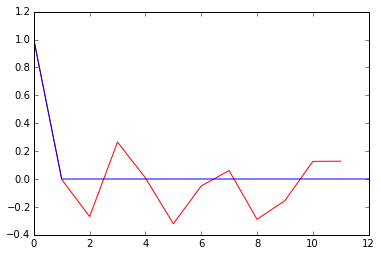

In [31]:
# plot the autocorrelation decay and the curve fit to the exponential
plt.plot(result,'r')
plt.plot(np.linspace(0,traj.n_frames,traj.n_frames+1), np.exp((-1./popt[-1])*np.linspace(0,traj.n_frames,traj.n_frames+1)))
#plt.savefig('p20_autocorr.pdf',format='pdf') # uncomment to save pdf of plot